# Data preparation GDL

#### 1) Vialidades vía OSM

In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder

In [3]:
training_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/'
input_folder = training_folder + r'inputs/'

In [4]:
if manual:
    %matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

##### 1.1) Lectura de zonificación y creación de máscara

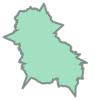

In [5]:
# Lectura de la zonificación
zones = gpd.read_file(r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/inputs/zones/zones.shp')

# Creacion de la mascara
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)

#Ploteo de la mascara
hull


##### 1.2) Request de vialidades usando la máscara

In [6]:
drive = ox.graph_from_polygon(hull, network_type='drive')

##### Visualización de vialiades

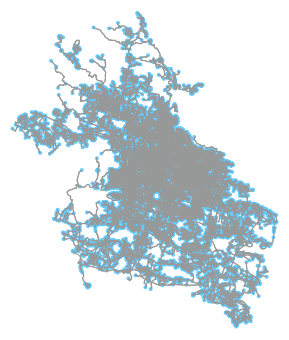

In [7]:
plot = ox.plot_graph(drive)


##### 1.3) Creación de DF road_nodes y roade_links

In [8]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

#### 1.4) Modificación nombres columnas de road links y road nodes

In [9]:
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)


##### 1.5) cleaning

In [10]:
from shapely import geometry
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])

In [11]:
road_links['geometry'] = road_links['geometry'].apply(simplify_link)
oc = OsmnxCleaner(
    road_links,
    road_nodes,
    a='from',
    b='to'
)

In [12]:
oc.add_reversed_links(
    direction_column='oneway',
    reverse_value=False # the boolean has been stored as a string
)
oc.clean_geometries()
oc.fix_nodeset_consistency()


##### 1.6) Creación del primer SM, integración de datos viales y Exportación


In [13]:
### Primera creación del SM , se le integra el road_links y road_nodes correspondientes a la red vial
from quetzal.model.stepmodel import StepModel

sm = StepModel(epsg=4326, coordinates_unit='degree')
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']].copy()
sm.road_nodes = oc.nodes[['geometry']].copy()


SQLalchemy is not installed. No support for SQL output.


In [14]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 120882it [00:24, 4947.37it/s]
reversed: 120882it [00:23, 5209.69it/s]
120075it [00:24, 5001.36it/s]


In [ ]:
#####           ELIMINAMOS ESTA SECCION , EN EL CODIGO ORIGINAL ESTA PRESENTE PERO NOSOTROS TOMAREMOS TODOS LOS TIPOS DE VIALIDAES   ##########
#sm.road_links['highway'] = sm.road_links['highway'].astype(str)
#irrelevant = ['pedestrian', 'footway', 'service', 'cycleway', 'residential']
#sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]

In [ ]:
### EXPORTACION
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

### 2) Importación de GTFS (version Santo Domingo) e integración de la zonificación al SM

In [1]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')

from quetzal.io.gtfs_reader import  gtfs_importer
from quetzal.model import stepmodel
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]


SQLalchemy is not installed. No support for SQL output.


In [2]:
input_folder= 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Data/inputs/'

## Lectura de los GTFS BASE
gtfs_zip = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Data/inputs/gtfs_quetzal.zip'
gtfs_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Data/inputs/input_gtfs/'

In [3]:
### Aqui desempaco los gtfs en el archivo input gtfs
import shutil
import os
try:
    shutil.rmtree(gtfs_folder)
except FileNotFoundError:
    pass
os.mkdir(gtfs_folder)
shutil.unpack_archive(gtfs_zip, gtfs_folder)

##### Lectura de los GTFS

In [4]:
importer = gtfs_importer.BaseGtfsImporter(gtfs_folder)
importer.read()

In [38]:
d = importer.stop_times.groupby(['trip_id']).first()['stop_id']
importer.trips['direction_id'] = importer.trips['trip_id'].apply(lambda i: d[i])

##### Visualización de la importación de los GTFS

In [5]:
### Se importaror directamente los ardchivos txt
d = importer.stop_times.groupby(['trip_id']).first()['stop_id']
importer.trips['direction_id'] = importer.trips['trip_id'].apply(lambda i: d[i])
importer.stop_times.head(1)

trip_id arrival_time departure_time  stop_id  stop_sequence  \
0  BUSES_GDL001001      0:01:02        0:01:02        1              1   

  stop_headsign  
0        Camino

##### Visualización de nombres de rutas

In [6]:
print(set(importer.routes['route_short_name']))


{'H14', 'V16', 'H5', 'H2', 'H8', 'V22', 'V13', 'V6', 'V10', 'H15', 'H10', 'H7', 'V3', 'V20', 'H11', 'V12', 'H16', 'V9', 'V19', 'V5', 'H12', 'V17', 'V21', 'V18', 'H13', 'H3', 'V15', 'V2', 'V4', 'V23', 'V11', 'H1', 'V7', 'V14', 'H6', 'H4', 'V1', 'H9', 'V8'}


In [7]:
importer.routes.sort_values('route_type')[['route_short_name', 'route_type']].to_csv(input_folder + 'test.csv', sep=';')
importer.cast_columns_to_string(columns=['trip_id', 'route_id', 'stop_id'])


stop_times ['trip_id', 'stop_id'] converted to string
trips ['route_id', 'trip_id'] converted to string
routes ['route_id'] converted to string
stops ['stop_id'] converted to string


##### Renumber

In [8]:
###  ¿¿¿¿  que se hace aqui ?????
start_from = 1000000
proto = importer.stops.sort_values('stop_id').reset_index(drop=True)
proto.index = proto.index + start_from
r_dict = proto.reset_index().set_index(['stop_id'])['index'].to_dict()
importer.stops['stop_id'] =importer.stops['stop_id'].apply(lambda i: r_dict[i])
importer.stop_times['stop_id'] =importer.stop_times['stop_id'].apply(lambda i: r_dict[i])

##### Construcción de links y visualización

In [9]:
#### Crea el archivo links dentro de importer
importer.build()
importer.links.head(1)


index        a          trip_id  link_sequence  departure_time        b  \
0      0  1000000  BUSES_GDL001001              1            62.0  1001089   

   arrival_time  time      route_id  direction_id  service_id  trip_headsign  \
0         124.0  62.0  BUSES_GDL001             1           1              1   

  trip_short_name         shape_id  agency_id route_short_name  \
0  Vertical 1 Ida  BUSES_GDL001001  BUSES_GDL               V1   

  route_long_name  route_type                                        geometry  
0      Vertical 1           3  LINESTRING (-103.477 20.799, -103.4769 20.796)

##### Cambio de nombre por tipo de modalidad

In [24]:
### Recordemos que en los GTFS las modalidades están representados por numeros siendo el 3 los buses
importer.links['route_type'] = importer.links['route_type'].apply(
    lambda t: {
        0:'tram',
        1:'subway',
        2:'rail',
        3:'bus',
        4:'ferry',
        5:'cable_car',
        6:'gondola',
        7:'funicular',
        702: 'express_bus'
    }[t]
)


##### Lectura y visualizacion de la zonificacion

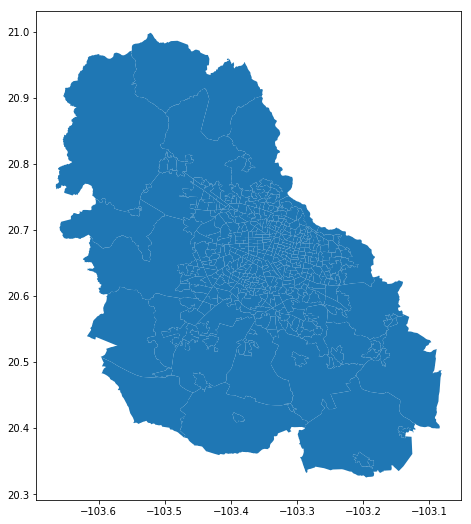

In [25]:
# Lectura de la zonificación
zones = gpd.read_file(r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/inputs/zones/Zonificacion.shp')
zones.plot()
## Se integrara la zonificacion al SM

##### Modificación de la Zonificación
###### Existen poligonos sin viajes, o con valires NA hay que eliminar esos poligonos

##### Lectura de resultado estudio OD

In [26]:
Matriz_OD = pd.read_csv('C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Data/inputs/data/OD2007.csv', encoding='latin', sep=';')
## Renombramiento de columnas
Matriz_OD.rename(columns={'ï»¿Origen': 'Origen'}, inplace=True)

# Visualizacion de los nombres de las columas
list(Matriz_OD.columns)

['Origen',
 'Destino',
 'Caminando',
 'Transporte Colectivo',
 'Taxi',
 'Bicicleta',
 'Motocicleta',
 'Auto (Conductor)',
 'Auto (Pasajero)',
 'Camioneta (Conductor)',
 'Camioneta (Pasajero)',
 'Otros',
 'Total']

##### Viajes totales del DF tomando como referencia que estos datos corresponden al estudio de 2014

In [20]:
Matriz_OD.Total.sum()

10688585

##### Población total al momento del estudio (2014)

In [27]:
POB2014=4636514
print(POB2014)

4636514


##### Viajes al día  por persona

In [28]:
Viajes_per_capita= Matriz_OD.Total.sum() / POB2014
print(Viajes_per_capita)


2.3053063141834578


##### Agrupamiento de total de viajes generados por zona

In [29]:
Generados = Matriz_OD.groupby(['Origen'])['Total'].sum()
Generados= Generados.to_frame() # Lo convertimos a DF porque lo genera orignalmente como serie
Generados['ID_2'] = Generados.index # Le damos la columna
Generados.head(4)

Total  ID_2
Origen              
1        13501     1
2       124100     2
3        42315     3
4       120906     4

##### Agrupamiento del total de viajes atraidos por zona

In [30]:
Atraidos = Matriz_OD.groupby(['Destino'])['Total'].sum()
Atraidos= Atraidos.to_frame() # Lo convertimos a DF porque lo genera orignalmente como serie
Atraidos['ID_2'] = Atraidos.index # Le damos la columna
Atraidos.head(4)


Total  ID_2
Destino              
1         13500     1
2        123948     2
3         42343     3
4        121311     4

##### Vinculación de viajes totales atraidos y generados con el GEO DF de la zonificación de estudio

In [31]:
# Merging DF con un GEODF de los viajes generados
zones = zones.merge(Generados, on='ID_2') # el primer elemento es el espacial

#Renombre
zones.rename(columns={'Total': 'Total_Generados'}, inplace=True)

### NOTA: EL merge lo hace bien pero no coiciden del todo los datos de generación con los que tiene
#el archivo de zonificacion (zonas)     VERLO CON EL IMEPLAN
#Info: https://geopandas.org/docs/user_guide/mergingdata.html

In [32]:
# Merge con el GEO DATA FRAME con el DF cde los viajes atraidos
zones = zones.merge(Atraidos, on='ID_2') # el primer elemento es el espacial

#Renombre
zones.rename(columns={'Total': 'Total_Atraidos'}, inplace=True)

##### Eliminación de columnas inecesarias

In [33]:
del zones ["POB2005"]
del zones ["POB2000"]
del zones ["VIAJES_AUT"]
del zones ["VIAJES_TP"]
del zones ["Viaje_tot"]
del zones ["trip_perso"]

##### Visualiuzación de viajes generados por zona

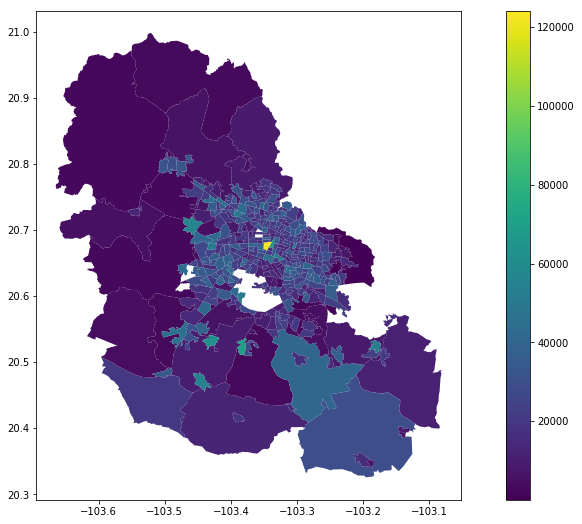

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
zones.plot(column= 'Total_Generados',ax=ax, legend=True)

##### Visualización de viajes atraidos por zona

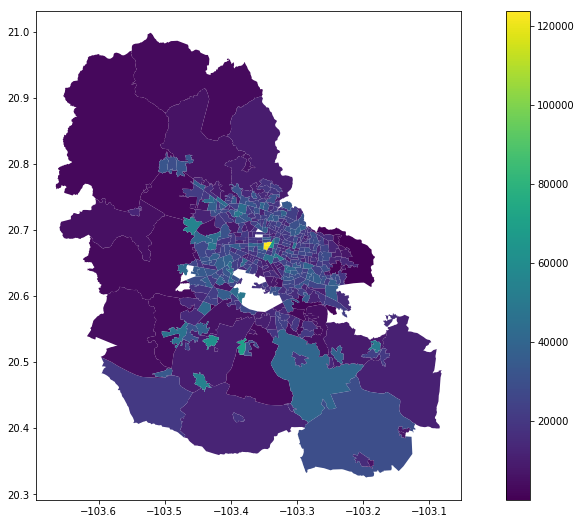

In [35]:
fig, ax = plt.subplots(1, 1)
zones.plot(column= 'Total_Atraidos',ax=ax, legend=True)


##### Integración de links y nodos generados a partir de los GTFS, asi como la zonificación

In [36]:
sm = stepmodel.StepModel()
sm.links = importer.links
sm.nodes = importer.stops.set_index('stop_id')[['geometry']]
sm.nodes['stop_id'] = sm.nodes.index
sm.zones = zones

## Aqui se sigue metiendo al sm los resultados,  SM ahora tambien contiene nodos y links de la red de transporte publico

<AxesSubplot:>

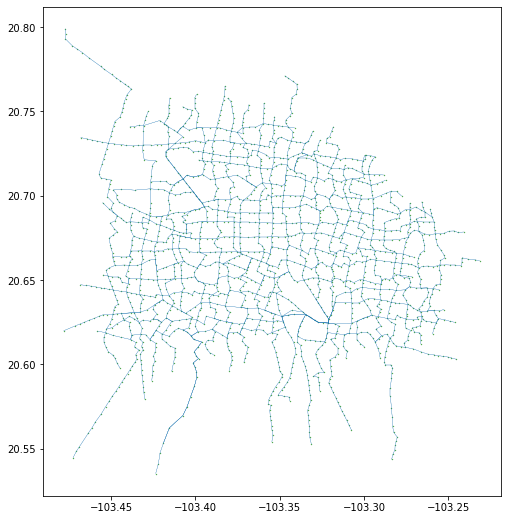

In [31]:
plot = gpd.GeoDataFrame(sm.links).plot(linewidth=0.2)
gpd.GeoDataFrame(sm.nodes).plot(ax=plot, color='green', markersize=0.1)

##### Exportación

In [28]:
training_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/'
input_folder = training_folder + r'inputs/'

### PRIMERO SE exporta en formato JSON (GEOJSON)
sm.to_json(input_folder + 'gtfs', only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|██████████| 32/32 [00:03<00:00, 10.21it/s]


In [29]:
##### Esto de nuevo se exporta a JSON pero Exporta TODO el SM a GEJOSN
sm.to_zippedpickles(training_folder + r'model/base/base')

utility_values: 100%|██████████| 32/32 [00:00<00:00, 78.99it/s]


### 3) Integridad de la red

In [32]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [31]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')
from quetzal.model import stepmodel, model
import geopandas as gpd
if manual:
    %matplotlib inline


In [32]:
training_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/'
input_folder = training_folder + r'inputs/'
plot_path = training_folder + 'outputs/plot/'

##### 3.1) Lectura del sm de TP

In [33]:
## Nota: lo que se está leyendo aqui es el SM pero esta en formato JSON todo lo que leera
sm = stepmodel.read_zippedpickles(training_folder + 'model/base/base')

zone_to_transit: 100%|██████████| 32/32 [00:00<00:00, 319.98it/s]


In [34]:
### Generar el índice como stop ID en el DF de nodos de TP
sm.nodes.index = sm.nodes['stop_id']

##### 3.2) Lecture de road_links y road_nodos (red vial)

In [35]:
road_links = gpd.read_file(input_folder+'road/road_links.geojson', driver='GeoJSON')
road_nodes = gpd.read_file(input_folder+'road/road_nodes.geojson', driver='GeoJSON')
road_nodes.set_index('index', inplace=True)


##### 3.3) Integración de los road_links y los road_nodes al SM

In [36]:
sm.road_links = road_links
sm.road_nodes = road_nodes


##### Inspección de los road_links (links de las vialidades)

In [37]:
road_links.head()


index           a           b   length  \
0      1  6347554816  1639281613   46.602   
1      2  6347554816  6347554804   43.200   
2      3  6347554816  6347554799  113.432   
3      4  6347554817  6347554804   57.049   
4      5  6347554817  1643880278  153.992   

                                            geometry  
0  LINESTRING (-103.26875 20.63910, -103.26915 20...  
1  LINESTRING (-103.26875 20.63910, -103.26889 20...  
2  LINESTRING (-103.26875 20.63910, -103.26776 20...  
3  LINESTRING (-103.26940 20.63889, -103.26889 20...  
4  LINESTRING (-103.26940 20.63889, -103.27083 20...

##### 3.4) Evaluación de la integridad de la red vial

In [38]:
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


##### Road fix

In [39]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)


direct: 116620it [00:27, 4190.74it/s]
reversed: 116620it [00:22, 5097.86it/s]
116620it [00:23, 4993.49it/s]


##### Road test

In [40]:
sm.integrity_test_dead_ends()

116620it [00:06, 17273.10it/s]


In [41]:
sm.integrity_fix_nodeset_consistency()

In [42]:
sm.integrity_test_isolated_roads()


##### 3.5) Evaluación de la integridad de la red de transporte

##### Transport fix

In [43]:
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()

##### Testeo de la red TP

In [44]:
sm.integrity_fix_nodeset_consistency()

In [45]:
sm.integrity_test_circular_lines()
sm.integrity_test_collision()
sm.integrity_test_nodeset_consistency()
sm.integrity_test_sequences()

In [46]:
sm.integrity_test_all(errors='raise')


passed: integrity_test_circular_lines
passed: integrity_test_collision
passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency
passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


116620it [00:06, 17030.86it/s]
116620it [00:22, 5079.65it/s]


In [47]:
### Cambio de proyecciones del SM
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter') ### CHECAR BIEN AQUI ESTO, ESTA PROYECCION NO SERÁ VALIDA PARA GDL
# aqui hay ejemoplo de uno proyeccion que si jalaria con GDL:

# projected = sm.change_epsg(32619, 'meter') # Aqui miso al crear el nuevo SM se le cambia de proyeccion

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████| 38/38 [00:26<00:00,  1.46it/s]


##### 3.6) Visualización de la red vial corregida

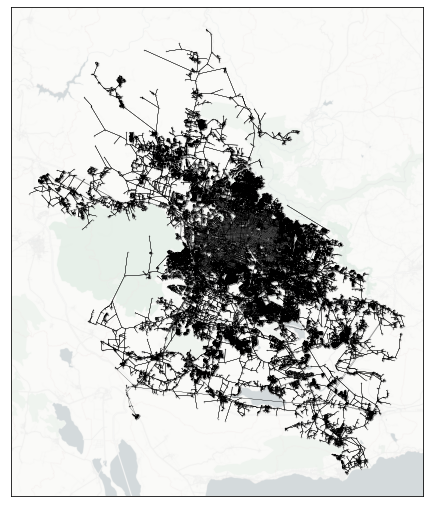

In [48]:
if manual:
    sm.plot(
        'road_nodes', color='grey', markersize=0.2,
        ax=sm.plot(
            'road_links', figsize=[16, 9],
            basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', linewidth=0.2, color='black'
        ),
    )


##### 3.7) Exportación del SM

In [49]:
### Este SM contiene la zonificación, el road_links, road_nodes (red vial) y los links y nodos del TP
sm.to_zip(training_folder + 'model/base/networks.zip')


jsons: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s]        


### 4) Networkcaster

In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')
import pandas as pd
from quetzal.model import stepmodel, model

if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/'

##### 4.1) Lectura del SM

In [4]:
sm = stepmodel.read_zip(training_folder + 'model/base/networks.zip')
# El SM llamada networks, contiene links nodos del TP, road_links road_nodes de la vialidades
# y la zonificacion


zones: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]      


##### 4.2) A realizarse en una red limpia, antes de la agregación

In [5]:
sm.integrity_fix_sequences()

In [6]:
sm.integrity_fix_nodeset_consistency()
sm.integrity_test_all(errors='raise', verbose=False)


116620it [00:05, 19842.34it/s]
116620it [00:22, 5227.41it/s]


##### 4.3) Se elimino esta seccion porque era la parte de rails


##### 4.4) Separación de buses (creando el objeto road)

In [7]:
## Aqui nuevamente hace una separación del SM original y solo se queda con los links de los buses
# esto lo hace en el nuevo SM  "road"
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [ ]:
##  EXPLICACION DEL NETWORKCASTER
# Public transport timetables and road networks are key inputs to many studies, but often
# come from independent sources; it is common to use the Open Street Map road network, and
# PT data from a GTFS database. Hence, they are rarely connected, but
# it is necessary to link them in order to model their physical interactions
# such as the impact of private car traffic on the commercial speed of
# road-based public modes.  Each stop can be linked to many road nodes
# and it is uncommon for the nearest one to be most optimal one.
# Several solutions have been developed to overcome this issue (Poletti, 2016), (Vuurstaek, 2018) and a similar
# one was implemented in Quetzal. In this way, the network and PT data can be maintained independently
# and efficiently merged when building the model.

##### 4.5) Vinculación de las líneas de buses con los road_links (las vialides) y sus nodos

In [8]:
## recordemos que road es el SM filtrado que ahora solo contiene buses
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5,
    n_neighbors=5,
    penalty_factor=2,
    replace_nodes=False
)
### segun yo aqui lo que hace es que prepara la vinculación de la red de buses con la de vialidades

## AQUI SE GENERAN COLUMNAS NUEVAS en el DF de links dentro del SM de road (que recordemos que contiene las lineas de TP)
# Estas columnsa nuevas son:
#  1) road_a
# 2) road_b
# 3) road_node_list
# 4) road_link_list
# 5) road_length


# POR ENDE, lo que hizo fue que vinculo las líneas de buses con las vialidades tanto los ID de los road_links como los nodos


BUSES_GDL022002: 100%|██████████| 78/78 [00:31<00:00,  2.48it/s]


### 4.6) Se vuelven a unir a un SM

In [9]:
# Recordemos, lo que se realizó anteriormente fue que primeramente se separaron los links de buses por una parte
# y TP masivo por la otra. Ambos pasaron por un proceso de vinculación con la red viales
# ahora en el DF de links está los ID de las vialidades que son parte de ese trayecto
both = road.copy()
# both.links = pd.concat([road.links, rail.links])  #esto se modifico al de paris, aqui no hubo rails

In [10]:
both.analysis_lines(line_columns='all')

### IMPORTANTE: aqui se agrega al SM "both" el DF de LINES que contiene la info vinculada a las rutas de TP

##### 4.7) Exportación

In [11]:
both.to_zip(training_folder + 'model/base/road_model.zip' )

jsons: 100%|██████████| 27/27 [00:12<00:00,  2.22it/s]                   


### 5) Walk model

In [11]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])


In [12]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
if manual:
    %matplotlib inline



In [14]:
training_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/'

##### 5.1) Lectura del SM "road model"

In [15]:
sm = stepmodel.read_zip(training_folder + r'model/base/road_model.zip')
# Recordemos que el SM "road model" contiene:
# 1) zonificación, 2) DF de lines, 3) road_links
# 4) road_model 5) links y nodos del TP ya vincuilados a los ID viales


zones: 100%|██████████| 27/27 [00:05<00:00,  5.17it/s]        


##### 5.2) Clusterización

In [16]:
sm.preparation_clusterize_nodes(300) # group_id='parent_station'
# Se genera el DF de "node_cluster" y "node paranthood"

# especialmente el "node paranthood" genera una clusterización de paradas y asigna un ID a cada cluster de paradas. (entienedo que las que están dentro de un radio de 300 m de cercania)

##### 5.3) Foothpaths

In [17]:
sm.preparation_footpaths(max_length=2000)

# Genera contenido para el DF de footpaths, genera una matriz de OD de tiempos de caminada
# Me falta analizarlo mejor porque no se entre que  y que son esos traslados

##### 5.4) Acceso y salida

In [18]:
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3,
    long_leg_speed=7,
    threshold=threshold,
    zone_to_transit=True,
    zone_to_road=True,
    n_ntlegs=5
)

##### 5.5) Exportación

In [19]:
sm.to_zip(training_folder + 'model/base/walk_model.zip')

jsons: 100%|██████████| 27/27 [00:12<00:00,  2.22it/s]                 


##### 5.6) Visualización de la clusterización


In [20]:
#####  Preparación de la funcion de visualización
def plot_clustering(self, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True)
    plot = sm.plot(
        'disaggregated_nodes', markersize=10, color='green',
        basemap_url=url, title="Original Stops", fontsize=36, ax=ax_array[0][0],
    )
    plot = sm.plot(
        'node_parenthood', linewidth=1,
        ax=sm.plot('disaggregated_nodes',  markersize=10, color='green', ax=ax_array[0][1]),
        basemap_url=url, title="Stop Clusters", fontsize=36
    )
    plot = sm.plot(
        'nodes', color='green', markersize=10,
        ax=sm.plot('node_clusters', alpha=0.25, edgecolor='black', ax=ax_array[1][0]),
        basemap_url=url, title="Stop Clusters", fontsize=36
    )
    plot = sm.plot(
        'nodes', color='green', markersize=50, basemap_url=url,
        title="Aggregated stops", fontsize=36, ax=ax_array[1][1]
    )
    return fig


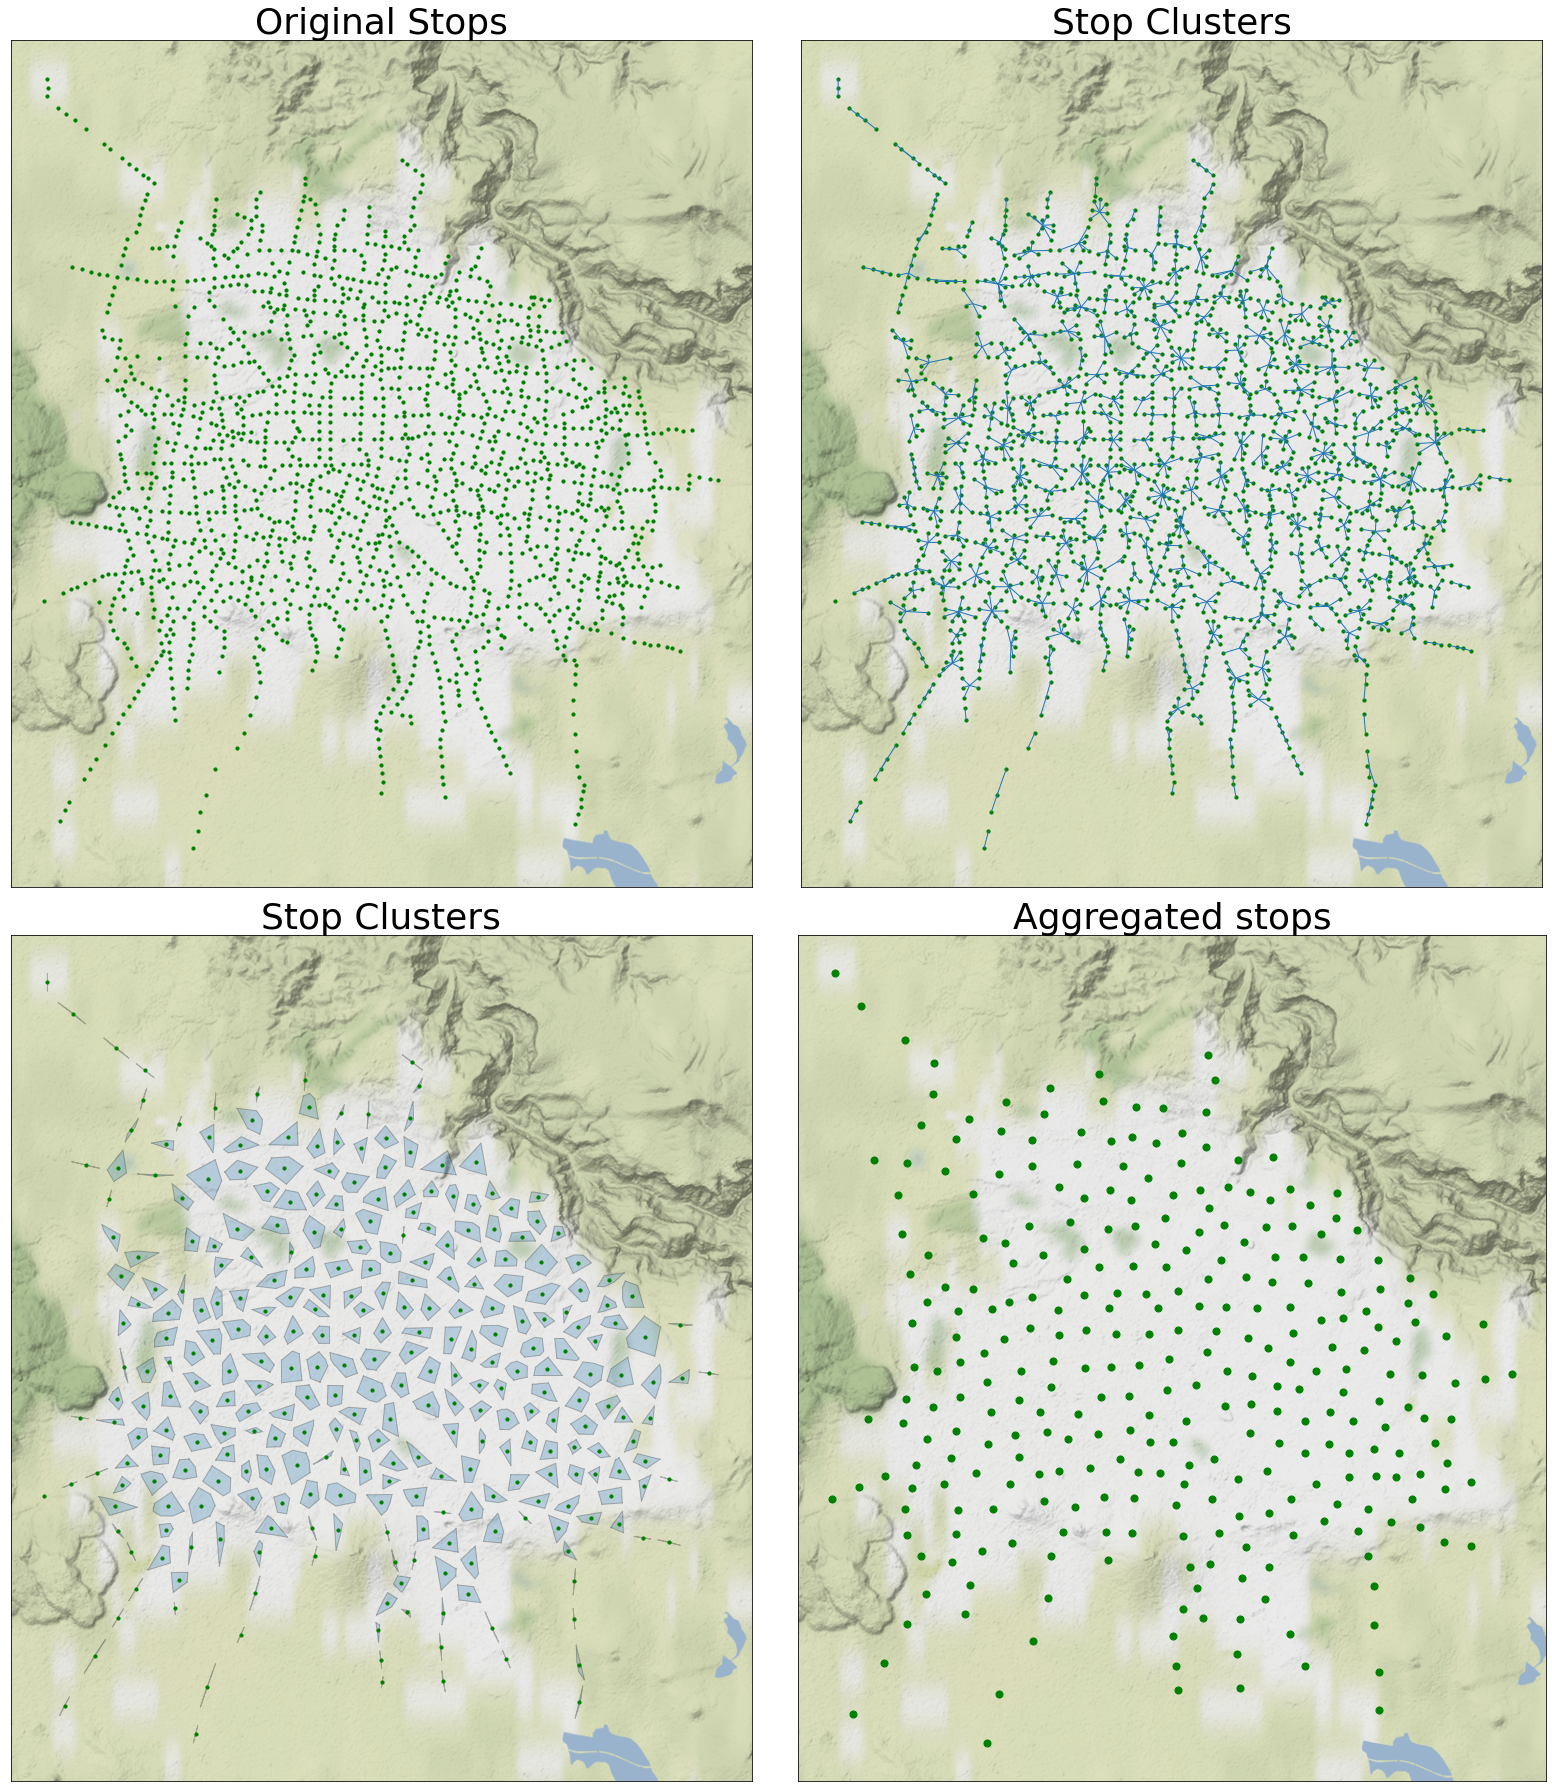

In [21]:
#### Visualización
if manual:
    fig = plot_clustering(sm, url='http://tile.stamen.com/terrain-background/tileZ/tileX/tileY.png')


##### 5.7) Visualización del modelo walk (ya de lo caminado)

In [22]:
### Definicion de la funcion de visualizacion de lo caminado

def plot_walkmodel(self, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True)
    plot = sm.plot('centroids', color='red', markersize=100,
        ax=sm.plot('nodes', markersize=10, color='red',
            ax=sm.plot('zone_to_transit', linewidth=1,
                      ax=sm.plot('zones', linewidth=1, alpha=1, edgecolor='black', color='none',
                                ax=sm.plot('footpaths', alpha=0, ax=ax_array[0][0])))
        ),
        basemap_url=url,
        title="Acces and Egress links (Zone to Transit)", fontsize=36
    )
    plot = sm.plot(
        'footpaths', color=None, linewidth=1,
        ax=sm.plot('nodes', markersize=100, ax=sm.plot('zones',alpha=0, ax=ax_array[0][1])),
        basemap_url=url, title="Stops & Footpaths", fontsize=36
    )

    plot = sm.plot(
        'footpaths', color=None, linewidth=1,
        ax=sm.plot('zone_to_transit', linewidth=1,  ax=sm.plot('zones',alpha=0, ax=ax_array[1][0]) ),
        basemap_url=url,
        title="Full Pedestrian Graph (as the Crow Flies)", fontsize=36
    )
    plot = sm.plot('road_links', color='green',linewidth=0.5, ax=sm.plot(
        'road_to_transit',  linewidth=1, color='green',
        ax=sm.plot('zone_to_road', linewidth=1, color='green', ax=sm.plot('zones',alpha=0, ax=ax_array[1][1]) )),
        basemap_url=url,
        title="Full Pedestrian Graph (Walk on Road)", fontsize=36
    )
    return fig



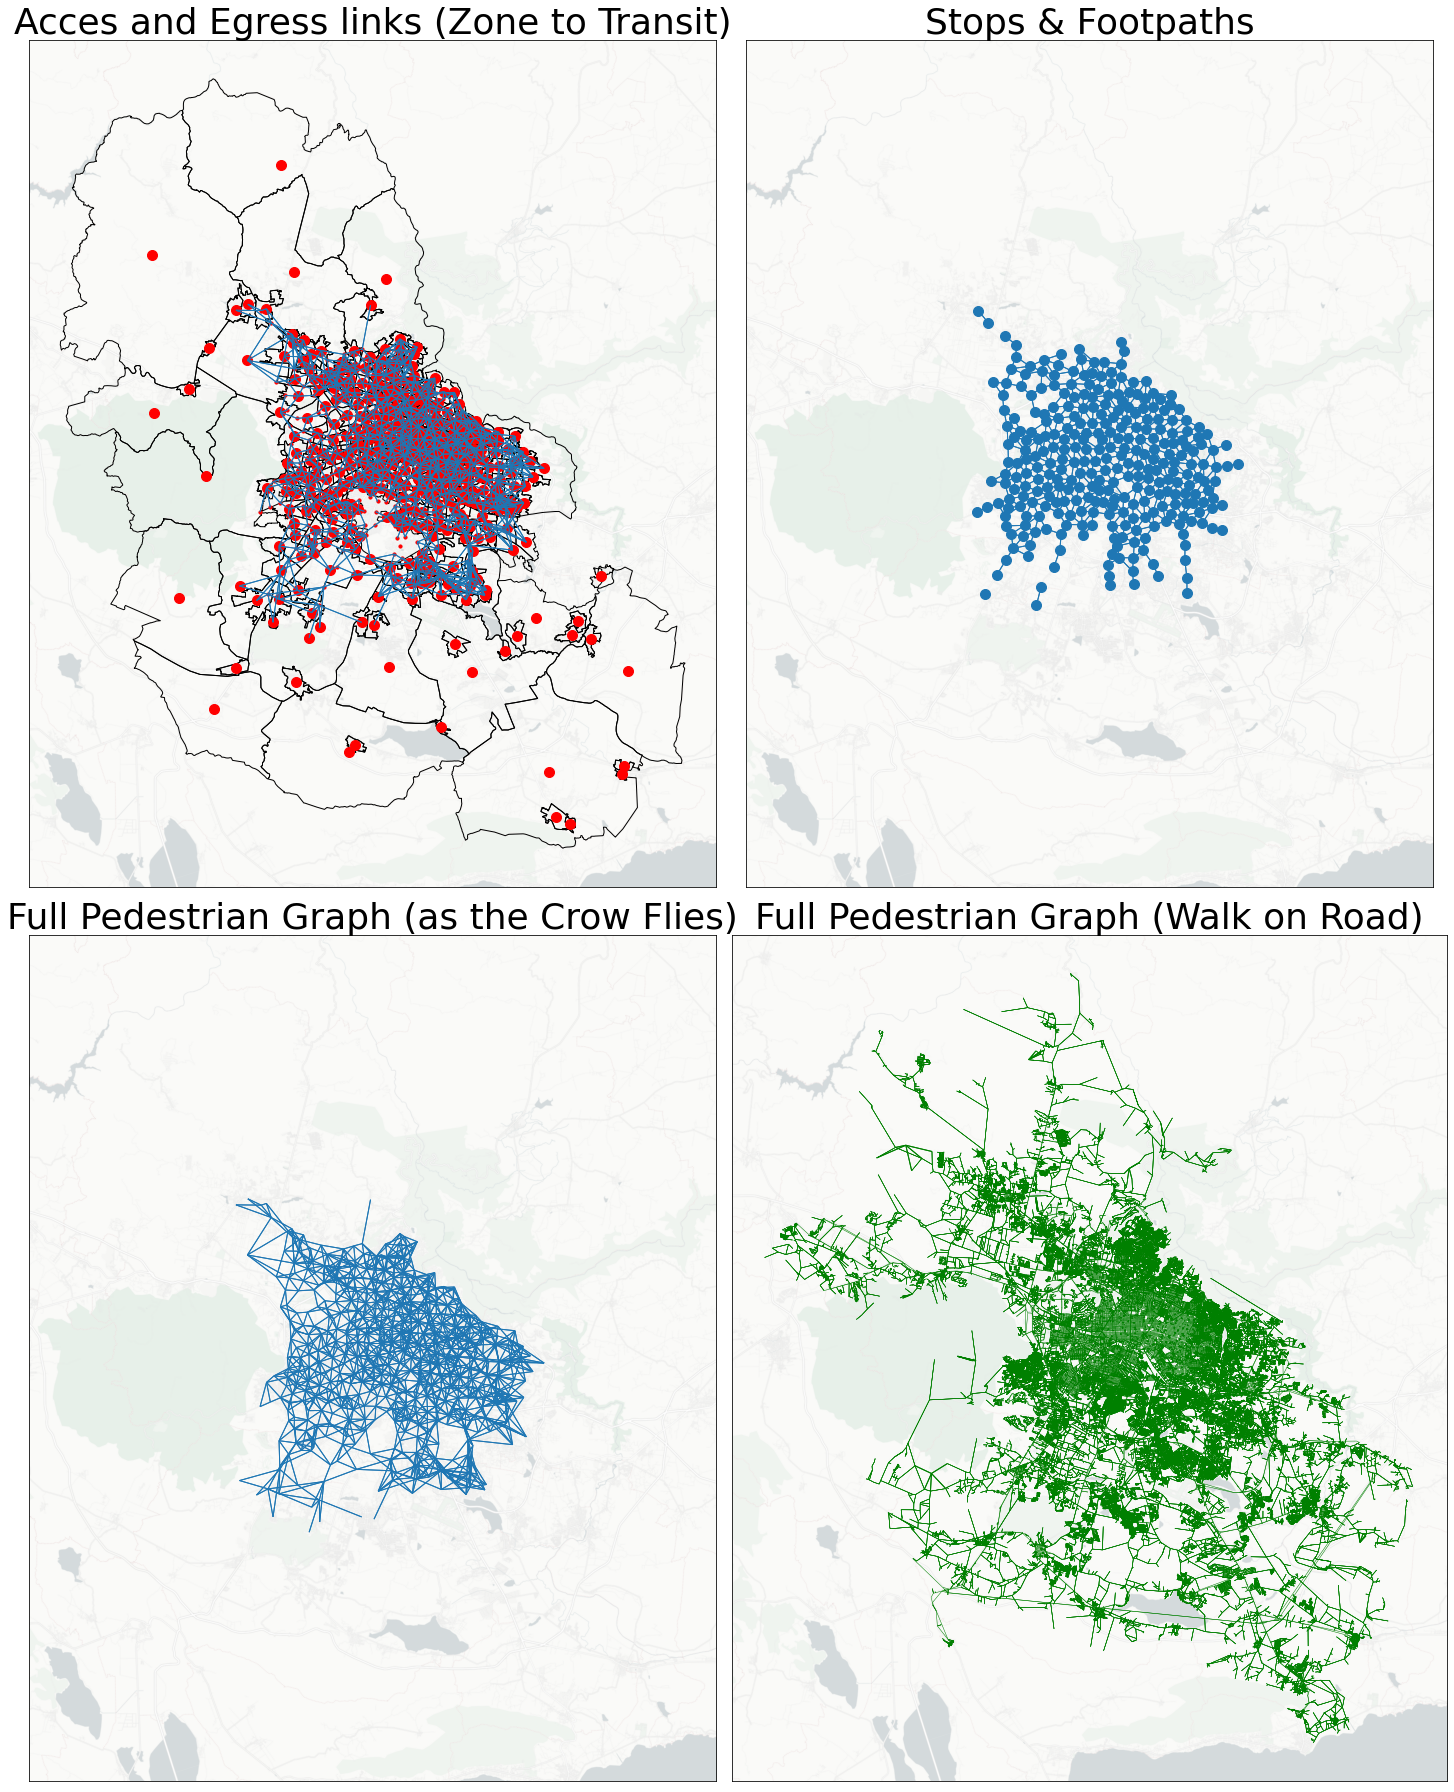

In [23]:
### Visualizacion
if manual:
    fig = plot_walkmodel(sm, url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png')

##### 5.8) Visulización de acceso y salida vs tiempo , y velocidad y distancia

Text(0.5, 1.0, 'Access & egress links: speed VS distance')

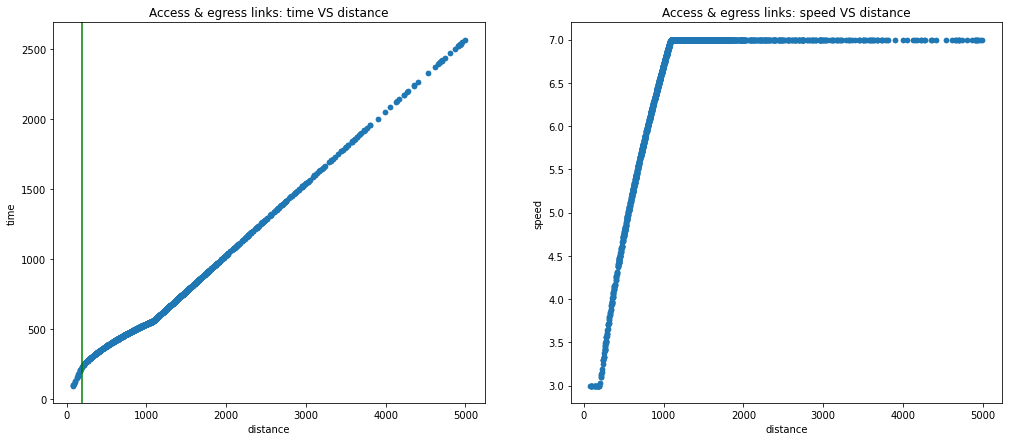

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=[17, 7])
ax = sm.zone_to_transit.plot(kind='scatter', x='distance', y='time', ax=axes[0])
ax.axvline(x=threshold, color='green')
ax.set_title('Access & egress links: time VS distance')
ax = sm.zone_to_transit.plot(kind='scatter', x='distance', y='speed', ax=axes[1])
ax.set_title('Access & egress links: speed VS distance')


### 6) All or nothing pathfinder
####     Aqui se hace el car_patfinder y el pt_pathfinder
###### El codigo de Pathfinder lo que hace es que encuentra los caminos relevantes para cada par OD, no solo encuentra el optimo sino que busca más, cada uno de estos caminos tendrá una utilidad vivnculada a el precio y tiempo que tome elegir cada opcion, esto se usaraá en el modelo de distribucion modal pues se usara esta utilidad de los caminnos para conocer la utilidad de la modalidad y tambien se usara en el submodelo de asignacion puesto que este tanbien se basa en un modelo de eleccion discreta y usara las utilidades de las disitancas opciones de camino de viaje para dar una distribucion de la probabilidad de eleccion de cierta ruta

##### NOTA ACTUAL: El codigo se llama All or nothing pero aqui realmente lo que se genera de novedoso es el PT_LOS y el CAR_LOS que son las matrices de  tiempos de desplazamiento entre cada par OD. Esto será utilidado en las posteriores etapas de modelación


In [7]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [8]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')

from quetzal.model import stepmodel
import os
import pandas as pd
if manual:
    %matplotlib inline

from quetzal.io import excel


In [9]:
training_folder = 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/'

##### 6.1) Lectura del SM
###### En este punto el SM NO CONTIENE EL car_los ni el Pt_los

In [10]:
sm = stepmodel.read_zip( r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/model/base/walk_model.zip'.format(scen='base'))
# se lee el SM de walk model

zones: 100%|██████████| 27/27 [00:05<00:00,  5.25it/s]                    


##### 6.2) Añadir velocidad promedio al TP

In [11]:
bus = sm.links.loc[sm.links['route_type'] == 'bus'] ## aqui Solo se queda con las rutas de buses
bus_lines = bus.groupby('route_id')[['time', 'road_length']].sum() # aqui se tendran el TIEMPO de traslado y la distancia de cada segmento vial de las rutas de los buses
## NOTA IMPORATNTE: En los GTFS no viene directramente las velocidades medias de los buses o del TP
# Sin embargo, contiene los TIEMPOS de llegada y salida de una stop y se puede conocer la distancia que se tiene de stop a stop.

In [12]:
### Calculo de la velocidad media (dada la explicacion anterior)
bus_speed = (bus['road_length'].sum() / bus['time'].sum()) *0.92 # LO VAMOS A MODIFICAR
print('bus_speed =', bus_speed, 'm/s')

# NOTA: se podría seguir este procedimiento O generar darle un valor DIRECTAMENTE a la variable "bus_speed"

bus_speed = 6.646322319233906 m/s


##### 6.3) Asignación  del headway al TP

In [13]:
# Se hará la modificacion tomando el headway declarado en los parámetros puestos para cada modalidad
var= excel.read_var( file= 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Data/inputs/parameters_gdl_paris.xlsx')
var.head()

# Dentro de el DF de var existen las filas que contienen el headway para cada modalidad

category  parameter        
general   parent               base
          bus_speed_factor      0.8
          boarding_cost_acf     300
          boarding_cost_wor     300
          routes_code          base
Name: base, dtype: object

In [16]:
headway = var['headway'].to_dict()
sm.links['headway'] = sm.links['route_type'].apply(headway.get)  # Le asgina el headway del DF de paramatros de acuerdo a la modalidad

In [17]:
sm.links['length'] = sm.links['road_length'] # aqui simplemente añada una nueva columna "length" que es igual
# a otra coliumna que ya existe "road_length" queda en el mismo DF de links

##### 6.4) Añadir velocidades medias a los vehiculos

In [18]:
# Velocidad de autos
car_speed = bus_speed * 1.12 # aqui simplmente dice que la velocidad media de los vehiculos es
# 25 % más rapida de los buses

print('car_speed =', car_speed, 'm/s')

car_speed = 7.443880997541975 m/s


In [19]:
## IMPORTATE: aqui lo que hace es que añade una nueva columna a road_links (de redes viales y vinculado en este caso a uno de autos)
# de tiempos de traslado utilizando la velecidad media dada de alta anteriromente y la longitud de la vialidad que ya se tiene
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s


##### 6.5) Añadir tiempos de desplazamiento caminando

In [20]:
# los peatones caminan sobre la calle por lo que se usará la longitud de la calle y los tiempos que se hace en auto que ya se tienen
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walking is  three times slower than car


##### 6.6) Path finder buses (Generación de tiempos de viaje de los OD )

In [21]:
# Walk on road, people walk on the road network, slow computation

## SUPER IMPORTANTE:   "SE GENEREA el PT_LOS"
# la funcion step_pt_pathfinder genera los DF de pt_los en los cuales se contiene los tiempos de desplazamiento de todos los pares OD en TP
wor = sm.copy()  # Se crea un SM nuevo llamado "wor"
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

path_analysis: 100%|██████████| 188356/188356 [00:07<00:00, 23797.91it/s]


#####  Visualización del PT_LOS


In [22]:
wor.pt_los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188356 entries, 0 to 188355
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   origin              188356 non-null  object 
 1   destination         188356 non-null  object 
 2   gtime               188356 non-null  float64
 3   path                188356 non-null  object 
 4   pathfinder_session  188356 non-null  object 
 5   reversed            188356 non-null  bool   
 6   boardings           188356 non-null  object 
 7   alightings          188356 non-null  object 
 8   node_path           188356 non-null  object 
 9   link_path           188356 non-null  object 
 10  footpaths           188356 non-null  object 
 11  ntlegs              188356 non-null  object 
 12  transfers           188356 non-null  object 
 13  boarding_links      188356 non-null  object 
 14  alighting_links     188356 non-null  object 
 15  all_walk            188356 non-nul

In [23]:
#### aqui se modifico, originalmente era el = "acf.pt_los"
sm.pt_los = wor.pt_los # aqui se queda con los PT_los que tiene no tiene walk_on_road=true

#### Visualización del pt_los

In [24]:
sm.pt_los.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188356 entries, 0 to 188355
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   origin              188356 non-null  object 
 1   destination         188356 non-null  object 
 2   gtime               188356 non-null  float64
 3   path                188356 non-null  object 
 4   pathfinder_session  188356 non-null  object 
 5   reversed            188356 non-null  bool   
 6   boardings           188356 non-null  object 
 7   alightings          188356 non-null  object 
 8   node_path           188356 non-null  object 
 9   link_path           188356 non-null  object 
 10  footpaths           188356 non-null  object 
 11  ntlegs              188356 non-null  object 
 12  transfers           188356 non-null  object 
 13  boarding_links      188356 non-null  object 
 14  alighting_links     188356 non-null  object 
 15  all_walk            188356 non-nul

##### 6.7) Path finder autos (Generación de tiempos de viaje de los OD en autos)

In [25]:
## Generacion del car_los (que son los tiempos de viaje de los OD en autos)
sm.step_road_pathfinder(all_or_nothing=True)


##### Visualización

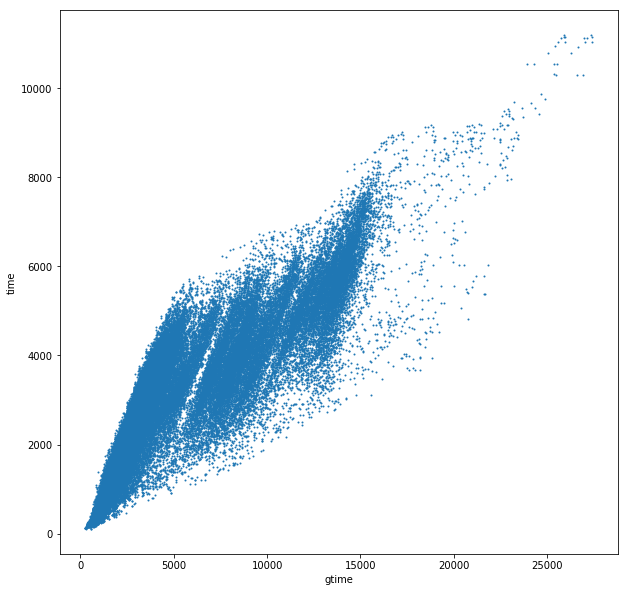

In [26]:
los = pd.merge(sm.pt_los, sm.car_los, on=['origin', 'destination'])
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='gtime', y='time', figsize=[10, 10], s=1)


##### 6.9) Exportación

In [27]:
sm.to_zip('C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/model/base/aon_pathfinder.zip'.format(scen=scenario))

car_los: 100%|██████████| 29/29 [00:20<00:00,  1.41it/s]                 


In [ ]:





##################################    LO ESTOY DESECHANDO TODO LO DE ABAJO        ##############################

## Pruning PT patfinder
###### Checar bien porque es lo mismo que arriba, simplemente siplificar el codigo, EN ESTE MOMENTO, ES NECESARIO. En el ejeccion con modelo se necesita el SM que se genera aqui

Prunning PT patfinder


In [28]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [29]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')

from quetzal.model import stepmodel
import os
import pandas as pd
if manual:
    %matplotlib inline

##### Lectura del walk model

In [34]:
sm = stepmodel.read_zip( r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/model/base/walk_model.zip'.format(scen='base'))
# se lee el SM de walk model


zones: 100%|██████████| 27/27 [00:05<00:00,  4.65it/s]                    


In [35]:
# add required fields
sm.links['length'] = sm.links['road_length']

var= excel.read_var( file= 'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Data/inputs/parameters_gdl_paris.xlsx')
var.head()

# Dentro de el DF de var existen las filas que contienen el headway para cada modalidad

category  parameter        
general   parent               base
          bus_speed_factor      0.8
          boarding_cost_acf     300
          boarding_cost_wor     300
          routes_code          base
Name: base, dtype: object

In [36]:
headway = var['headway'].to_dict()
sm.links['headway'] = sm.links['route_type'].apply(headway.get)  # Le asgina el headway del DF de paramatros de acuerdo a la modalidad


In [37]:
sm.links.drop(['index'], axis=1,inplace=True, errors='ignore')
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    route_column='route_short_name',
    walk_on_road= True
)


KeyError: 'walk_time'

##### Visualización


In [46]:
sm.pt_los.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 371796 entries, 0 to 188354
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   origin              371796 non-null  object 
 1   destination         371796 non-null  object 
 2   gtime               371796 non-null  float64
 3   path                371796 non-null  object 
 4   reversed            371796 non-null  bool   
 5   pathfinder_session  371796 non-null  object 
 6   broken_modes        371796 non-null  object 
 7   boardings           371796 non-null  object 
 8   alightings          371796 non-null  object 
 9   node_path           371796 non-null  object 
 10  link_path           371796 non-null  object 
 11  footpaths           371796 non-null  object 
 12  ntlegs              371796 non-null  object 
 13  transfers           371796 non-null  object 
 14  boarding_links      371796 non-null  object 
 15  alighting_links     371796 non-nul

In [47]:
sm.pt_los.head()


origin destination         gtime  \
0  zone_0      zone_0      0.000000   
1  zone_0      zone_1   1524.280407   
2  zone_0     zone_10  13196.533922   
3  zone_0    zone_100   4647.336581   
4  zone_0    zone_101   4301.023551   

                                                path  reversed  \
0                                          (zone_0,)     False   
1  (zone_0, 4738717039, 4738717043, 4738717041, 4...     False   
2  (zone_0, 4738717034, 4738717037, 4738717022, 4...     False   
3  (zone_0, 59, 365791395, 365790868, 365790867, ...     False   
4  (zone_0, 59, 365791395, 365790868, 365790867, ...     False   

  pathfinder_session broken_modes boardings alightings  \
0       mode_breaker        {bus}        []         []   
1       mode_breaker        {bus}        []         []   
2       mode_breaker        {bus}        []         []   
3       mode_breaker        {bus}        []         []   
4       mode_breaker        {bus}        []         []   

                                           node_path link_path  \
0                                                 []        []   
1  [4738717039, 4738717043, 4738717041, 473871703...        []   
2  [4738717034, 4738717037, 4738717022, 473871642...        []   
3  [59, 365791395, 365790868, 365790867, 38554662...        []   
4  [59, 365791395, 365790868, 365790867, 38554662...        []   

                                           footpaths  \
0                                                 []   
1  [(4738717039, 4738717043), (4738717043, 473871...   
2  [(4738717034, 4738717037), (4738717037, 473871...   
3  [(59, 365791395), (365791395, 365790868), (365...   
4  [(59, 365791395), (365791395, 365790868), (365...   

                                         ntlegs transfers boarding_links  \
0                                            []        []             []   
1  [(zone_0, 4738717039), (4740525037, zone_1)]        []             []   
2        [(zone_0, 4738717034), (133, zone_10)]        []             []   
3               [(zone_0, 59), (258, zone_100)]        []             []   
4        [(zone_0, 59), (1643880307, zone_101)]        []             []   

  alighting_links  all_walk  ntransfers  time_link_path  length_link_path  
0              []      True           0             0.0               0.0  
1              []      True           0             0.0               0.0  
2              []      True           0             0.0               0.0  
3              []      True           0             0.0               0.0  
4              []      True           0             0.0               0.0

##### Exportación


In [48]:
sm.to_zip('C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Modelo de Demanda GDL/Modelo GDL basado en paris/model/base/pruning_pt_pathfinder.zip'.format(scen=scenario))


pt_los: 100%|██████████| 28/28 [00:28<00:00,  1.01s/it]                


####  PRUEBA CON PARIS

In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')

from quetzal.model import stepmodel
import os
import pandas as pd
if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
sm_paris = stepmodel.read_zip(r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Ejemplo Paris/quetzal_paris-master/model/base/walk_model.zip'.format(scen='base'))

zones: 100%|██████████| 27/27 [00:00<00:00, 34.04it/s]                  


ADD speed on lnks

In [4]:
bus = sm_paris.links.loc[sm_paris.links['route_type'] == 'bus']
bus_lines = bus.groupby('route_id')[['time', 'road_length']].sum()
bus_speed = bus['road_length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s')

bus_speed = 3.530517707027077 m / s


In [6]:
# pt
sm_paris.links['headway'] = 300
sm_paris.links['length'] = sm_paris.links['road_length']

# road
car_speed = bus_speed * 1.25
sm_paris.road_links['time'] = sm_paris.road_links['length'] / car_speed # m/s

# walk
sm_paris.road_links['walk_time'] = sm_paris.road_links['time'] * 3 # walk three times slower than car

### PT Pathfinder
#### Walk on road

In [8]:
wor = sm_paris.copy()
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 46704.03it/s]


Visualizacion del PT_LOS generado

In [9]:
wor.pt_los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12100 entries, 0 to 12099
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   origin              12100 non-null  object 
 1   destination         12100 non-null  object 
 2   gtime               12100 non-null  float64
 3   path                12100 non-null  object 
 4   pathfinder_session  12100 non-null  object 
 5   reversed            12100 non-null  bool   
 6   boardings           12100 non-null  object 
 7   alightings          12100 non-null  object 
 8   node_path           12100 non-null  object 
 9   link_path           12100 non-null  object 
 10  footpaths           12100 non-null  object 
 11  ntlegs              12100 non-null  object 
 12  transfers           12100 non-null  object 
 13  boarding_links      12100 non-null  object 
 14  alighting_links     12100 non-null  object 
 15  all_walk            12100 non-null  bool   
 16  ntra

people walk on dedicated access and egress links only

In [11]:
acf = sm_paris.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 46154.51it/s]


##### Visualización del pt_los

In [12]:
acf.pt_los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12100 entries, 0 to 12099
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   origin              12100 non-null  object 
 1   destination         12100 non-null  object 
 2   gtime               12100 non-null  float64
 3   path                12100 non-null  object 
 4   pathfinder_session  12100 non-null  object 
 5   reversed            12100 non-null  bool   
 6   boardings           12100 non-null  object 
 7   alightings          12100 non-null  object 
 8   node_path           12100 non-null  object 
 9   link_path           12100 non-null  object 
 10  footpaths           12100 non-null  object 
 11  ntlegs              12100 non-null  object 
 12  transfers           12100 non-null  object 
 13  boarding_links      12100 non-null  object 
 14  alighting_links     12100 non-null  object 
 15  all_walk            12100 non-null  bool   
 16  ntra

#### here we chose to use the ACF paths

In [13]:
sm_paris.pt_los = acf.pt_los


Visualización del PT_LOS integrado al SM

In [15]:
sm_paris.pt_los.head()


origin destination        gtime  \
0  zone_0      zone_0     0.000000   
1  zone_0      zone_1   746.164214   
2  zone_0     zone_10  1196.467057   
3  zone_0    zone_100  1782.157960   
4  zone_0    zone_101  2103.179435   

                                                path pathfinder_session  \
0                                          (zone_0,)          best_path   
1                              (zone_0, 168, zone_1)          best_path   
2  (zone_0, 199, link_843, 188, link_2740, 86, zo...          best_path   
3  (zone_0, 168, link_4097, link_4098, link_4099,...          best_path   
4  (zone_0, 168, link_138, link_139, link_140, 59...          best_path   

   reversed       boardings      alightings            node_path  \
0     False              []              []                   []   
1     False              []              []                [168]   
2     False      [199, 188]       [188, 86]       [199, 188, 86]   
3     False      [168, 107]       [107, 74]       [168, 107, 74]   
4     False  [168, 59, 261]  [59, 261, 147]  [168, 59, 261, 147]   

                                           link_path footpaths  \
0                                                 []        []   
1                                                 []        []   
2                              [link_843, link_2740]        []   
3  [link_4097, link_4098, link_4099, link_4634, l...        []   
4  [link_138, link_139, link_140, link_4433, link...        []   

                             ntlegs  transfers  \
0                                []         []   
1    [(zone_0, 168), (168, zone_1)]         []   
2    [(zone_0, 199), (86, zone_10)]      [188]   
3   [(zone_0, 168), (74, zone_100)]      [107]   
4  [(zone_0, 168), (147, zone_101)]  [59, 261]   

                     boarding_links                   alighting_links  \
0                                []                                []   
1                                []                                []   
2             [link_843, link_2740]             [link_843, link_2740]   
3            [link_4097, link_4634]            [link_4099, link_4639]   
4  [link_138, link_4433, link_4292]  [link_140, link_4439, link_4293]   

   all_walk  ntransfers  time_link_path  length_link_path  
0      True           0             0.0             0.000  
1      True           0             0.0             0.000  
2     False           1           120.0           361.018  
3     False           1           660.0               NaN  
4     False           2           780.0               NaN

In [16]:
sm_paris.pt_los.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12100 entries, 0 to 12099
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   origin              12100 non-null  object 
 1   destination         12100 non-null  object 
 2   gtime               12100 non-null  float64
 3   path                12100 non-null  object 
 4   pathfinder_session  12100 non-null  object 
 5   reversed            12100 non-null  bool   
 6   boardings           12100 non-null  object 
 7   alightings          12100 non-null  object 
 8   node_path           12100 non-null  object 
 9   link_path           12100 non-null  object 
 10  footpaths           12100 non-null  object 
 11  ntlegs              12100 non-null  object 
 12  transfers           12100 non-null  object 
 13  boarding_links      12100 non-null  object 
 14  alighting_links     12100 non-null  object 
 15  all_walk            12100 non-null  bool   
 16  ntra

### Generación del CAR_LOS


In [18]:
sm_paris.step_road_pathfinder(all_or_nothing=True)

#### Visualización del car_los

In [19]:
sm_paris.car_los.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12100 entries, 0 to 12099
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   origin       12100 non-null  object 
 1   destination  12100 non-null  object 
 2   time         12100 non-null  float64
 3   path         12100 non-null  object 
 4   node_path    12100 non-null  object 
 5   link_path    12100 non-null  object 
 6   ntlegs       12100 non-null  object 
dtypes: float64(1), object(6)
memory usage: 756.2+ KB


### 2) Pruning PT pathfiinder

In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Quetzal Dev/quetzal-master')
from quetzal.model import stepmodel
import pandas as pd

SQLalchemy is not installed. No support for SQL output.


##### Se lee el SM de Walk model
###### Este no contiene ni pt_los ni car_los

In [4]:
sm_paris = stepmodel.read_zip(r'C:/Users/orlan/Documents/UPC/PhD/Papers/Paper 4/Ejemplo Paris/quetzal_paris-master/model/base/walk_model.zip'.format(scen=scenario))

zones: 100%|██████████| 27/27 [00:01<00:00, 25.30it/s]          


#### Route breaker: rail submodel

In [6]:
# add required fields
sm_paris.links['length'] = sm_paris.links['road_length']


In [8]:
rail = sm_paris.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]


In [9]:
rail.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False,
    route_column='route_short_name',
    mode_column='route_type',
    speedup=True
)


path_analysis: 100%|██████████| 34573/34573 [00:00<00:00, 46210.11it/s]


##### Visualización del PT_Los

In [10]:
rail.pt_los.info()
# broken route es una columna distinta

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34573 entries, 0 to 1750
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   origin              34573 non-null  object 
 1   destination         34573 non-null  object 
 2   gtime               34573 non-null  float64
 3   path                34573 non-null  object 
 4   pathfinder_session  34573 non-null  object 
 5   reversed            34573 non-null  bool   
 6   broken_route        22473 non-null  object 
 7   boardings           34573 non-null  object 
 8   alightings          34573 non-null  object 
 9   node_path           34573 non-null  object 
 10  link_path           34573 non-null  object 
 11  footpaths           34573 non-null  object 
 12  ntlegs              34573 non-null  object 
 13  transfers           34573 non-null  object 
 14  boarding_links      34573 non-null  object 
 15  alighting_links     34573 non-null  object 
 16  all_w

In [11]:
rail.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()


route_breaker    22473
best_path        12100
Name: pathfinder_session, dtype: int64

#### Mode breaker

In [12]:
### NUEVAMENTE genera el PT_los pero ahora directamaente en el SM originalmente leido
sm_paris.links.drop(['index'], axis=1,inplace=True, errors='ignore')

sm_paris.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    route_column='route_short_name'
)
#### Si hay una diferencia sustancial en el tipo de contenido de las columnas,  en los de patfinder session y broken modes

path_analysis: 100%|██████████| 78030/78030 [00:01<00:00, 50756.21it/s]


##### Visualización de las columnas

In [13]:
sm_paris.pt_los.head()


origin destination        gtime  \
0  zone_0      zone_0     0.000000   
1  zone_0      zone_1   746.164214   
2  zone_0     zone_10  2752.757133   
3  zone_0    zone_100  6680.598674   
4  zone_0    zone_101  8917.970490   

                                                path  reversed  \
0                                          (zone_0,)     False   
1                              (zone_0, 168, zone_1)     False   
2                    (zone_0, 199, 188, 86, zone_10)     False   
3    (zone_0, 187, 250, 193, 52, 148, 251, zone_100)     False   
4  (zone_0, 187, 186, 106, 100, 200, 34, 239, 147...     False   

  pathfinder_session               broken_modes boardings alightings  \
0       mode_breaker  {bus, tram, rail, subway}        []         []   
1       mode_breaker  {bus, tram, rail, subway}        []         []   
2       mode_breaker  {bus, tram, rail, subway}        []         []   
3       mode_breaker  {bus, tram, rail, subway}        []         []   
4       mode_breaker  {bus, tram, rail, subway}        []         []   

                                 node_path link_path  \
0                                       []        []   
1                                    [168]        []   
2                           [199, 188, 86]        []   
3            [187, 250, 193, 52, 148, 251]        []   
4  [187, 186, 106, 100, 200, 34, 239, 147]        []   

                                           footpaths  \
0                                                 []   
1                                                 []   
2                            [(199, 188), (188, 86)]   
3  [(187, 250), (250, 193), (193, 52), (52, 148),...   
4  [(187, 186), (186, 106), (106, 100), (100, 200...   

                             ntlegs transfers boarding_links alighting_links  \
0                                []        []             []              []   
1    [(zone_0, 168), (168, zone_1)]        []             []              []   
2    [(zone_0, 199), (86, zone_10)]        []             []              []   
3  [(zone_0, 187), (251, zone_100)]        []             []              []   
4  [(zone_0, 187), (147, zone_101)]        []             []              []   

   all_walk  ntransfers  time_link_path  length_link_path  
0      True           0             0.0               0.0  
1      True           0             0.0               0.0  
2      True           0             0.0               0.0  
3      True           0             0.0               0.0  
4      True           0             0.0               0.0

In [15]:
both = sm_paris.copy()

In [17]:
### Aqui lo que hace esque UNE el pt_los generado solo para rail y
both.pt_los = pd.concat(
    [sm_paris.pt_los, rail.pt_los]
).drop_duplicates(subset=['path'])

In [18]:
both.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()


mode_breaker     78030
route_breaker    18062
Name: pathfinder_session, dtype: int64

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


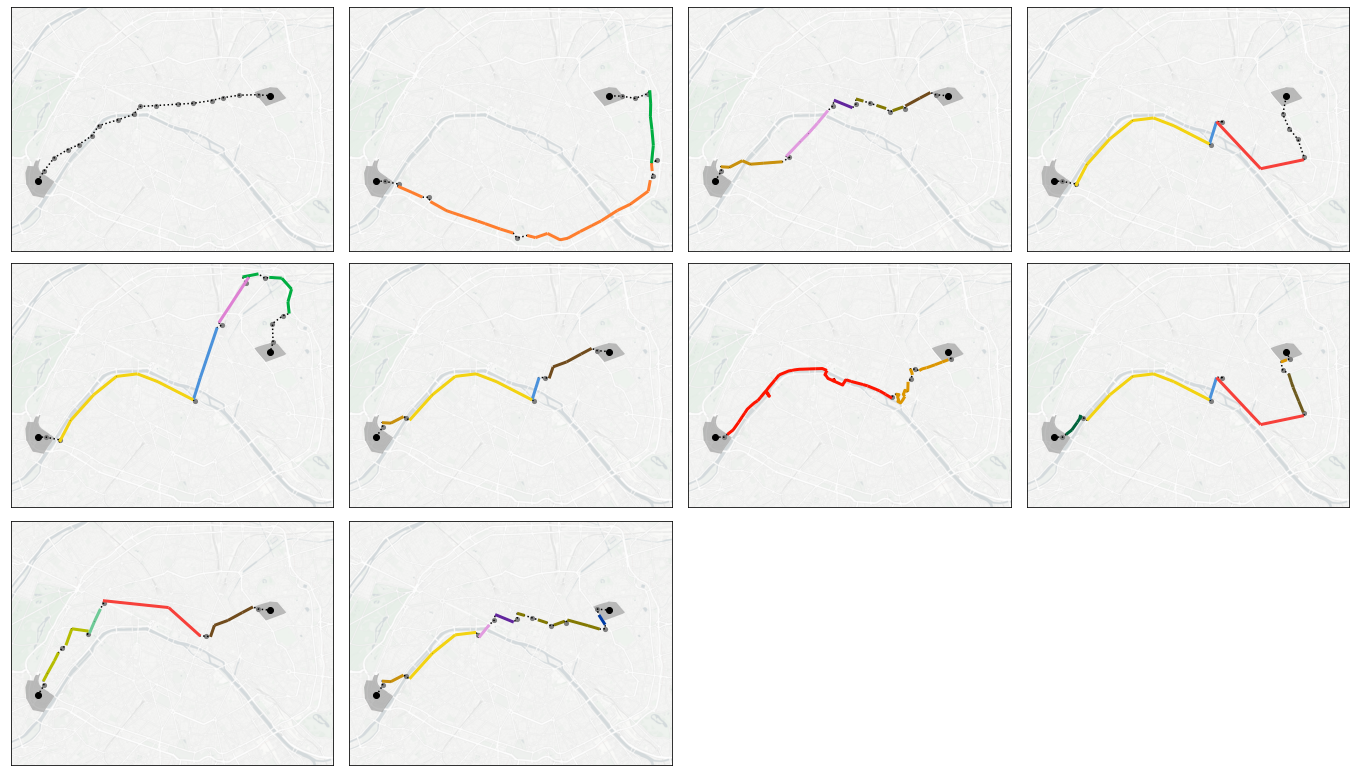

In [19]:
both.links['color'] = '#' + both.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = both.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png',
)

##### Exportación


In [ ]:
both.to_zip(training_folder + 'model/{scen}/pruning_pt_pathfinder.zip'.format(scen=scenario))

